### Importing libraries

In [1]:
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
from preprocessor.api import clean, tokenize, parse
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### Twitter credentials

In [2]:
#Twitter credentials for the app
consumer_key = 'xxxxx'
consumer_secret = 'xxxx'
access_key= 'xxxxx'
access_secret = 'xxxx'

### Credentials

Pass these credentials to Tweepy’s OAuthHandler instance named ‘auth’, then using that instance call the method set_access_token by passing the above-created access_key and, access_secret.

In [ ]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

### Creating file paths for the CSV file

In [3]:
tradewar_tweets = "tradewar.csv"

### Columns need for analysis

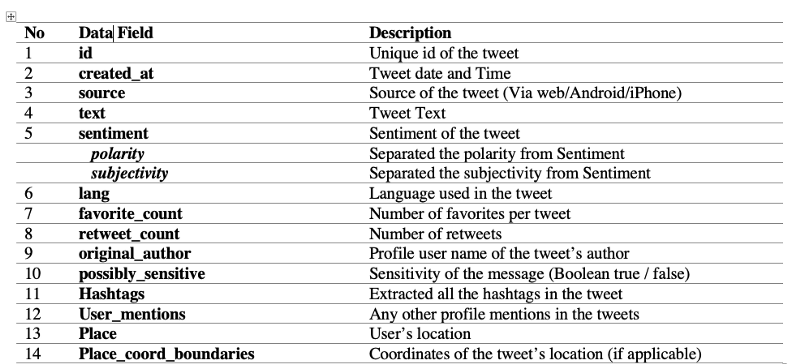

In [5]:
from IPython.display import display, Image
display(Image(filename='columns.png'))

In [4]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
        'user_mentions', 'place', 'place_coord_boundaries']

### Handle Emoticons and Emojis

A series of emoticons (Happy & Sad) and emojis not needed in the middle of a sentence which block the sentiment analysis.

In [ ]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

Method that will clean some remains of the twitter data which is left undone by the tweet preprocessor

In [5]:
#method clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

### Extract tweets

The method will take two parameters; the keyword to search the tweets about and the file to save all the tweets data.
The result received from the Twitter API is in a JSON format and has quite an amount of information attached.
An array of string name new_entry=[] is created to store all the JSON parsed data on each iteration only retrieve data that is in English.
The sentiment property returns a named tuple of the form Sentiment(polarity,subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. The filtered_tweet is being passed to TextBlob for sentiment calculation separately store sentiment, polarity, and subjectivity in three different variables. Later on, all the JSON parsed data is appended to the string array which was created.
Regarding the location, the location of user's profile is fetched rather than the tweet's.
The last step is to write in the csv

In [6]:
#set two date variables for date range
start_date = '2019-05-13'

#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(1000):
        for status in page:
            new_entry = []
            status = status._json
            
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
                
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
            
            #tweepy preprocessing called for basic preprocessing
            clean_text = clean(status['text'])
            
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
            
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
            
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
            
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
            
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
            
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
            
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
            
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
            
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
            
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

Selecting hashtags and search for the tweets containing them to filter out the tweets only related to the topic

In [7]:
#declare keywords as a query for three categories
tradewar_keywords = '#uschinatrade OR #uschinatradewar OR #uschinatradewars OR #uschina OR #tradewar OR #tradewars OR #tradedeal OR #tariffs -filter:retweets AND -filter:replies'

In [8]:
#call main method passing keywords and file path
write_tweets(tradewar_keywords,  tradewar_tweets)